## GRU model testing
OK, we have done carry forward control, we have done simple linear models, we have done ARIMA - last thing to try before going on a data hunt in true neural network based models. We could try some regression with vanilla dense layers or something, but I think we should cut to the chase and go straight to a GRU based network. Let's get a minimal example set up to get an idea of what we are working with and then set up a more rigorous hyperparameter optimization with crossvalidation/bootstrapping.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import shelve
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

# Add notebook parent dir to path so we can import from functions/
import sys
sys.path.append('..')

# Import project config file
import config as conf

# Import notebooks specific helper functions
import functions.notebook_helper_functions.notebook15 as funcs

# Instantiate paths and model parameters
paths = conf.DataFilePaths()
params = conf.GRU_model_parameters()

# Load data column index
index = shelve.open(paths.PARSED_DATA_COLUMN_INDEX)

# Set number of counties to include in our testing
num_counties = 100

# Set data block size 
block_size = 9

In [2]:
for column, num in index.items():
    print(f'{column}: {num}')

cfips: 0
first_day_of_month: 1
microbusiness_density: 2
active: 3
microbusiness_density_change: 4
microbusiness_density_change_change: 5


In [3]:
# Load data with block size
input_file = f'{paths.PARSED_DATA_PATH}/{params.input_file_root_name}{block_size}.npy'
timepoints = np.load(input_file)

OK, so here we go. Hardest part about working with this type of model is getting the data into the correct shape for input. Couple of considerations here:
1. Do training/validation split where data is kept in sequential time order with older data being used for training and newer data being used for validation.
2. Start with only one input feature - the microbusiness density (or detrended microbusiness density).
3. Forecast one point into the future.
4. Be ready to standardize/unstandardize data using statistics from the training set only.
5. Input data is formatted as (batch, timesteps, feature). 

The last part is a little complicated to think about - we have > 3k timeseries with the same time axis, one for each county. We could treat this like 3k features, but I think the better idea is to think of it as one feature and 3k counties * 37 timepoints input datapoints. The trick is, how do we batch/make timesteps out of it? We don't want to present the model timeseries from different counties as if one comes after the next. I think the most obvious way to do this is use a stateless GRU layer and then present each county as a batch. Within that batch we then have the block from our sliding window data parse.

Ok, I think that sounds like as good a place to start as any. Let's take a look at the data:

In [4]:
print(f'Input data shape: {timepoints.shape}')

Input data shape: (29, 3135, 9, 6)


The dimensions here are:

0. The timepoint block - the sized of this axis depends on the width of the block used to scan the data - smaller blocks give more timepoints with num_timepoint_blocks = total_timepoints - block_size + 1. This is also the axis we need to do our training validation split on. First part becomes training, last part becomes validation.
1. The counties - each element here is a county, for the purposes of our first experiment with this we will treat each county as a batch.
2. The the timepoints in the timepoint block (~row in pandas dataframe).
3. The features (~column in pandas dataframe). To start with, we will work with one feature only - the microbusiness density.

First up - training/validation split:

In [5]:
# Choose split
split_index = int(timepoints.shape[0] * params.training_split_fraction)

# Before we split, choose just the data we want and drop everything else
input_data = timepoints[:,:,:,[index[params.input_data_type]]]

# Split data into training and validation sets using chosen
# index. First portion becomes training, second portion
# is validation
training_data = input_data[0:split_index]
validation_data = input_data[split_index:-1]

print(f'Input data shape: {input_data.shape}')
print(f'Split fraction: {params.training_split_fraction}')
print(f'Split index: {split_index}')
print(f'Training data shape: {training_data.shape}')
print(f'Validation data shape: {validation_data.shape}')

Input data shape: (29, 3135, 9, 1)
Split fraction: 0.7
Split index: 20
Training data shape: (20, 3135, 9, 1)
Validation data shape: (8, 3135, 9, 1)


OK, looks good - let's try converting everything to a z-score, using mean and standard deviation from the training sample only.

In [6]:
# Get mean and standard deviation from training data
training_mean = np.mean(training_data)
training_deviation = np.std(training_data)

print(f'Mean: {training_mean:.2f}, standard deviation: {training_deviation:.2f}')

# Standardize the training and validation data
training_data = (training_data - training_mean) / training_deviation
validation_data = (validation_data - training_mean) / training_deviation

print(f'Training data, new mean: {np.mean(training_data):.2f}, new standard deviation: {np.std(training_data):.2f}')
print(f'Validation data, new mean: {np.mean(validation_data):.2f}, new standard deviation: {np.std(validation_data):.2f}')

Mean: 3.77, standard deviation: 4.52
Training data, new mean: -0.00, new standard deviation: 1.00
Validation data, new mean: 0.03, new standard deviation: 1.31


In [7]:
# Swap first and second axis to make the data batch major, instead
# of time major - this is the more common format for tensorflow and what
# our GRU layer(s) will expect to see
training_data = np.swapaxes(training_data, 1, 0)
validation_data = np.swapaxes(validation_data, 1, 0)

print(f'New training data shape: {training_data.shape}')
print(f'New validation data shape: {validation_data.shape}')

New training data shape: (3135, 20, 9, 1)
New validation data shape: (3135, 8, 9, 1)


Looks good! Let's build the model. Only additional thing to mention here is that for each time block in the counties, the first n datapoints are the time ordered input and the last one is the value we are trying to predict. With that in mind, let's go!

In [8]:
def build_GRU(
    units: int = 64,
    learning_rate: float = 0.0002,
    input_shape: list[int] = [8,1]
):
    '''Builds GRU based neural network for
    microbusiness density regression'''

    # Input layer
    input = layers.Input(
        name = 'Input',
        shape = input_shape
    )

    # GRU layer
    gru = layers.GRU(
        units,
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        kernel_initializer="glorot_uniform",
        recurrent_initializer="orthogonal",
        bias_initializer="zeros",
        kernel_regularizer=None,
        recurrent_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        recurrent_constraint=None,
        bias_constraint=None,
        dropout=0.0,
        recurrent_dropout=0.0,
        return_sequences=False,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False,
        reset_after=True,
        name='GRU'
    )(input)

    # output layer
    output = layers.Dense(
        name = 'Output',
        units = 1,
        activation = 'linear'
    )(gru)

    # Next, we will build the complete model and compile it.
    model = keras.models.Model(
        input, 
        output,
        name = 'Simple_GRU_model'
    )

    model.compile(
        loss = keras.losses.MeanSquaredError(name = 'MSE'), 
        optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
        metrics = [keras.metrics.MeanAbsoluteError(name = 'MAE')]
    )

    print(model.summary())

    return model

In [9]:
def data_generator(data):
    '''Generates pairs of X, Y (input, target) datapoints
    from batch major data'''
    
    while True:
        # Loop on counties
        for i in range(data.shape[0]):
            # Loop on timepoints
            for j in range(data.shape[1]):
                
                X = data[i,j,:-1,:]
                Y = data[i,j,-1:,:]

                yield (X, Y)

# Start generator and grab a sample data point
training_data_generator = data_generator(training_data)
input_sample = next(training_data_generator)

# Check sample point's shape
print(f'Input shape: {input_sample[0].shape}')
print(f'Target shape: {input_sample[1].shape}')

Input shape: (8, 1)
Target shape: (1, 1)


In [10]:
# Build the model
model = build_GRU(
    units = 64,
    learning_rate = 0.0002,
    input_shape = [input_sample[0].shape[0],input_sample[0].shape[1]]
)

Model: "Simple_GRU_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 8, 1)]            0         
                                                                 
 GRU (GRU)                   (None, 64)                12864     
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda/'

In [12]:
# Fire data generators for training and validation
training_data_generator = data_generator(training_data)
validation_data_generator = data_generator(validation_data)

# Train the model
history = model.fit(
    training_data_generator,
    epochs = 10,
    batch_size = training_data.shape[1],
    steps_per_epoch = training_data.shape[0],
    validation_data = validation_data_generator,
    validation_batch_size = validation_data.shape[1],
    validation_steps = validation_data.shape[0]
)

Epoch 1/10
3135/3135 [==============================] - 23s 7ms/step - loss: 0.0211 - MAE: 0.0780 - val_loss: 1.0110 - val_MAE: 0.2061
Epoch 2/10
3135/3135 [==============================] - 20s 6ms/step - loss: 0.4261 - MAE: 0.1627 - val_loss: 0.3193 - val_MAE: 0.2468
Epoch 3/10
3135/3135 [==============================] - 20s 7ms/step - loss: 0.1109 - MAE: 0.1004 - val_loss: 0.0193 - val_MAE: 0.0256
Epoch 4/10
3135/3135 [==============================] - 20s 6ms/step - loss: 0.2918 - MAE: 0.0999 - val_loss: 0.0047 - val_MAE: 0.0416
Epoch 5/10
3135/3135 [==============================] - 21s 7ms/step - loss: 0.0401 - MAE: 0.0453 - val_loss: 1.9811 - val_MAE: 0.1058
Epoch 6/10
3135/3135 [==============================] - 21s 7ms/step - loss: 0.0121 - MAE: 0.0474 - val_loss: 0.0328 - val_MAE: 0.0567
Epoch 7/10
3135/3135 [==============================] - 21s 7ms/step - loss: 0.0100 - MAE: 0.0309 - val_loss: 0.0544 - val_MAE: 0.1706
Epoch 8/10
3135/3135 [==============================] -

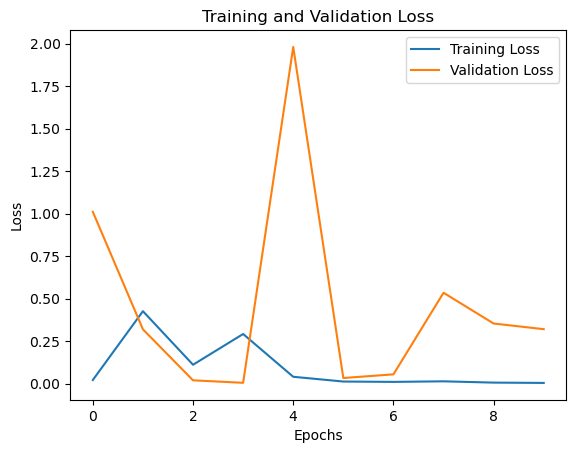

In [13]:
# Plot and label the training and validation loss values
plt.plot(list(range(len(history.history['loss']))), history.history['loss'], label='Training Loss')
plt.plot(list(range(len(history.history['val_loss']))), history.history['val_loss'], label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Display the plot
plt.legend(loc='best')
plt.show()